In [2]:
!pip install torchvision==0.16.0
!pip install seaborn
# 安装后点击上方 Restart the kernal

In [4]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
# from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [9]:
# 步骤二：加载数据集
# 2.1 设置超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.003
DOWNLOAD_CIFAR = False
DEVICE = 'cpu'

# 2.2 数据预处理
transform = transforms.Compose([
    # 请在此处编写代码：ToTensor 和 Normalize（均值与方差）
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# 2.3 检查是否需要下载数据集
if not(os.path.exists('./cifar/')) or not os.listdir('./cifar/'):
    DOWNLOAD_CIFAR = True

# 2.4 加载训练集和测试集
train_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=True,
    transform=transform,
    download=DOWNLOAD_CIFAR
)
test_data = torchvision.datasets.CIFAR10(
    root='./cifar/',
    train=False,
    transform=transform,
    download=DOWNLOAD_CIFAR
)

# 2.5 封装数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)   # 请在此处编写代码

test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)   # 请在此处编写代码

In [10]:
# 步骤三：CNN模型设计
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # 请在此处编写代码：Conv2d + BatchNorm2d + ReLU + MaxPool2d
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            # 请在此处编写代码：Flatten + Linear + ReLU + Dropout + Linear
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        # 请在此处编写代码
        x = self.conv(x)
        x = self.fc(x)
        return x

# 3.2 实例化模型并迁移到设备
cnn = CNN().to(DEVICE)  # 请在此处编写代码
print(cnn)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=F

In [11]:
# 步骤四：设置损失函数与优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # 请在此处编写代码：Adam优化器
criterion = nn.CrossEntropyLoss()  # 请在此处编写代码：交叉熵损失

In [13]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    cnn.train()  # 请在此处编写代码：切换到训练模式（model.train()）
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # 请在此处编写代码：将 inputs 和 targets 迁移到设备（to(DEVICE)）

        optimizer.zero_grad()  # 请在此处编写代码：清除梯度（optimizer.zero_grad）
        outputs = cnn(inputs)  # 请在此处编写代码：前向传播（model(inputs)）
        loss = criterion(outputs, targets)  # 请在此处编写代码：计算损失（criterion(outputs, targets)）
        loss.backward()  # 请在此处编写代码：反向传播（loss.backward）
        optimizer.step()  # 请在此处编写代码：参数更新（optimizer.step）

        epoch_loss += loss.item()  # 请在此处编写代码：累计损失（epoch_loss += loss.item()）

        # 可选：每 N 批次打印中间 loss
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx+1} Loss: {loss.item():.4f}")  # 请在此处编写代码：打印当前 batch 的平均 loss

    avg_epoch_loss = epoch_loss / len(train_loader)  # 请在此处编写代码：计算 epoch 平均 loss
    train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}] Average Train Loss: {avg_epoch_loss:.4f}")

# 5.2 定义测试函数（返回 acc，预测标签，真实标签）
def test():
    cnn.eval()  # 请在此处编写代码：切换模型为评估模式
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # 请在此处编写代码：关闭梯度计算（torch.no_grad）
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # 请在此处编写代码：数据迁移到DEVICE
            outputs = cnn(inputs)  # 请在此处编写代码：前向传播
            _, predicted = outputs.max(1)  # 请在此处编写代码：获取预测标签（outputs.max(dim=1)）
            # 请在此处编写代码：更新 total 和 correct 数量
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            # 请在此处编写代码：保存预测和真实标签到 all_preds 和 all_labels
            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())

    acc = 100. * correct / total  # 请在此处编写代码：计算准确率（百分比形式）
    pred_y = torch.cat(all_preds)
    true_y = torch.cat(all_labels)
    return acc, pred_y, true_y

# 5.3 开始训练过程
os.makedirs('./output', exist_ok=True)

for epoch in range(EPOCH):
    train(epoch)  # 请在此处编写代码：调用 train 函数
    acc, _, _ = test()  # 请在此处编写代码：调用 test 函数
    test_accuracies.append(acc)  # 请在此处编写代码：保存本轮测试准确率
    print(f"Test Accuracy after Epoch [{epoch+1}]: {acc:.4f}")

Training Epoch 1:   1%|          | 4/782 [00:08<20:23,  1.57s/it]  

Batch 1 Loss: 2.4108


Training Epoch 1:  14%|█▎        | 106/782 [00:12<00:26, 25.88it/s]

Batch 101 Loss: 1.8605


Training Epoch 1:  26%|██▌       | 205/782 [00:16<00:23, 24.81it/s]

Batch 201 Loss: 1.9046


Training Epoch 1:  39%|███▉      | 304/782 [00:20<00:19, 23.93it/s]

Batch 301 Loss: 1.6902


Training Epoch 1:  52%|█████▏    | 403/782 [00:24<00:16, 22.39it/s]

Batch 401 Loss: 1.3940


Training Epoch 1:  65%|██████▍   | 505/782 [00:28<00:11, 24.13it/s]

Batch 501 Loss: 1.5962


Training Epoch 1:  77%|███████▋  | 604/782 [00:32<00:07, 25.21it/s]

Batch 601 Loss: 1.3381


Training Epoch 1:  90%|████████▉ | 703/782 [00:36<00:03, 24.72it/s]

Batch 701 Loss: 1.5476


Training Epoch 1: 100%|██████████| 782/782 [00:40<00:00, 19.36it/s]


Epoch [1] Average Train Loss: 1.6471


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.75it/s]


Test Accuracy after Epoch [1]: 55.5100


Training Epoch 2:   1%|          | 4/782 [00:07<18:38,  1.44s/it]  

Batch 1 Loss: 1.8464


Training Epoch 2:  14%|█▎        | 106/782 [00:11<00:27, 24.97it/s]

Batch 101 Loss: 1.3279


Training Epoch 2:  26%|██▌       | 205/782 [00:15<00:22, 25.79it/s]

Batch 201 Loss: 1.1662


Training Epoch 2:  39%|███▉      | 304/782 [00:19<00:18, 25.78it/s]

Batch 301 Loss: 1.2722


Training Epoch 2:  52%|█████▏    | 406/782 [00:23<00:14, 25.27it/s]

Batch 401 Loss: 1.3252


Training Epoch 2:  65%|██████▍   | 505/782 [00:27<00:11, 25.00it/s]

Batch 501 Loss: 1.2400


Training Epoch 2:  77%|███████▋  | 604/782 [00:31<00:07, 25.24it/s]

Batch 601 Loss: 1.1748


Training Epoch 2:  90%|█████████ | 706/782 [00:35<00:03, 24.47it/s]

Batch 701 Loss: 1.2178


Training Epoch 2: 100%|██████████| 782/782 [00:38<00:00, 20.11it/s]


Epoch [2] Average Train Loss: 1.2892


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.78it/s]


Test Accuracy after Epoch [2]: 65.1100


Training Epoch 3:   1%|          | 4/782 [00:07<18:37,  1.44s/it]  

Batch 1 Loss: 1.1379


Training Epoch 3:  13%|█▎        | 105/782 [00:11<00:27, 24.46it/s]

Batch 101 Loss: 1.0429


Training Epoch 3:  26%|██▌       | 204/782 [00:15<00:22, 25.40it/s]

Batch 201 Loss: 1.1661


Training Epoch 3:  39%|███▊      | 303/782 [00:19<00:20, 23.28it/s]

Batch 301 Loss: 1.0568


Training Epoch 3:  52%|█████▏    | 405/782 [00:23<00:14, 25.21it/s]

Batch 401 Loss: 1.3607


Training Epoch 3:  64%|██████▍   | 504/782 [00:27<00:10, 25.35it/s]

Batch 501 Loss: 1.2034


Training Epoch 3:  77%|███████▋  | 606/782 [00:31<00:06, 25.59it/s]

Batch 601 Loss: 1.2447


Training Epoch 3:  90%|█████████ | 705/782 [00:35<00:03, 25.63it/s]

Batch 701 Loss: 1.3003


Training Epoch 3: 100%|██████████| 782/782 [00:39<00:00, 19.95it/s]


Epoch [3] Average Train Loss: 1.1260


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.91it/s]


Test Accuracy after Epoch [3]: 65.2500


Training Epoch 4:   1%|          | 4/782 [00:07<18:52,  1.46s/it]  

Batch 1 Loss: 1.0000


Training Epoch 4:  14%|█▎        | 106/782 [00:11<00:26, 25.20it/s]

Batch 101 Loss: 0.9455


Training Epoch 4:  26%|██▌       | 205/782 [00:15<00:22, 25.85it/s]

Batch 201 Loss: 1.0204


Training Epoch 4:  39%|███▉      | 304/782 [00:19<00:18, 25.98it/s]

Batch 301 Loss: 1.2321


Training Epoch 4:  52%|█████▏    | 406/782 [00:23<00:14, 25.56it/s]

Batch 401 Loss: 1.3127


Training Epoch 4:  65%|██████▍   | 505/782 [00:27<00:11, 24.29it/s]

Batch 501 Loss: 1.1366


Training Epoch 4:  77%|███████▋  | 604/782 [00:31<00:07, 25.41it/s]

Batch 601 Loss: 0.9497


Training Epoch 4:  90%|█████████ | 706/782 [00:35<00:02, 25.85it/s]

Batch 701 Loss: 1.1629


Training Epoch 4: 100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


Epoch [4] Average Train Loss: 1.0221


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.88it/s]


Test Accuracy after Epoch [4]: 68.6600


Training Epoch 5:   1%|          | 4/782 [00:07<18:24,  1.42s/it]  

Batch 1 Loss: 1.0792


Training Epoch 5:  14%|█▎        | 106/782 [00:11<00:26, 25.47it/s]

Batch 101 Loss: 0.8815


Training Epoch 5:  26%|██▌       | 205/782 [00:15<00:22, 25.63it/s]

Batch 201 Loss: 1.2324


Training Epoch 5:  39%|███▉      | 304/782 [00:19<00:19, 24.25it/s]

Batch 301 Loss: 0.8461


Training Epoch 5:  52%|█████▏    | 406/782 [00:23<00:14, 25.35it/s]

Batch 401 Loss: 1.1303


Training Epoch 5:  65%|██████▍   | 505/782 [00:27<00:10, 25.61it/s]

Batch 501 Loss: 0.8617


Training Epoch 5:  77%|███████▋  | 604/782 [00:31<00:07, 24.30it/s]

Batch 601 Loss: 0.9332


Training Epoch 5:  90%|█████████ | 706/782 [00:35<00:03, 24.82it/s]

Batch 701 Loss: 1.1498


Training Epoch 5: 100%|██████████| 782/782 [00:38<00:00, 20.11it/s]


Epoch [5] Average Train Loss: 0.9493


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.69it/s]


Test Accuracy after Epoch [5]: 73.1600


Training Epoch 6:   1%|          | 4/782 [00:07<18:27,  1.42s/it]  

Batch 1 Loss: 0.9622


Training Epoch 6:  14%|█▎        | 106/782 [00:11<00:26, 25.66it/s]

Batch 101 Loss: 0.9047


Training Epoch 6:  26%|██▌       | 205/782 [00:15<00:23, 25.00it/s]

Batch 201 Loss: 1.0740


Training Epoch 6:  39%|███▉      | 304/782 [00:19<00:19, 25.11it/s]

Batch 301 Loss: 0.9921


Training Epoch 6:  52%|█████▏    | 406/782 [00:23<00:14, 25.47it/s]

Batch 401 Loss: 0.9259


Training Epoch 6:  65%|██████▍   | 505/782 [00:27<00:10, 25.83it/s]

Batch 501 Loss: 0.8934


Training Epoch 6:  77%|███████▋  | 604/782 [00:31<00:07, 24.93it/s]

Batch 601 Loss: 0.6964


Training Epoch 6:  90%|█████████ | 706/782 [00:35<00:02, 25.54it/s]

Batch 701 Loss: 0.7033


Training Epoch 6: 100%|██████████| 782/782 [00:38<00:00, 20.23it/s]


Epoch [6] Average Train Loss: 0.8799


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.71it/s]


Test Accuracy after Epoch [6]: 71.1500


Training Epoch 7:   1%|          | 4/782 [00:07<18:30,  1.43s/it]  

Batch 1 Loss: 0.8159


Training Epoch 7:  14%|█▎        | 106/782 [00:11<00:26, 25.11it/s]

Batch 101 Loss: 0.7992


Training Epoch 7:  26%|██▌       | 205/782 [00:15<00:22, 25.28it/s]

Batch 201 Loss: 0.8955


Training Epoch 7:  39%|███▉      | 304/782 [00:19<00:18, 26.08it/s]

Batch 301 Loss: 0.5732


Training Epoch 7:  52%|█████▏    | 406/782 [00:23<00:14, 25.17it/s]

Batch 401 Loss: 0.7348


Training Epoch 7:  65%|██████▍   | 505/782 [00:27<00:11, 24.94it/s]

Batch 501 Loss: 0.8446


Training Epoch 7:  77%|███████▋  | 604/782 [00:31<00:06, 25.60it/s]

Batch 601 Loss: 0.7969


Training Epoch 7:  90%|█████████ | 706/782 [00:35<00:03, 25.06it/s]

Batch 701 Loss: 0.6325


Training Epoch 7: 100%|██████████| 782/782 [00:38<00:00, 20.16it/s]


Epoch [7] Average Train Loss: 0.8091


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.74it/s]


Test Accuracy after Epoch [7]: 73.9900


Training Epoch 8:   1%|          | 4/782 [00:07<18:27,  1.42s/it]  

Batch 1 Loss: 0.9589


Training Epoch 8:  14%|█▎        | 106/782 [00:11<00:26, 25.43it/s]

Batch 101 Loss: 0.9025


Training Epoch 8:  26%|██▌       | 205/782 [00:15<00:22, 25.75it/s]

Batch 201 Loss: 0.8035


Training Epoch 8:  39%|███▉      | 304/782 [00:19<00:19, 24.81it/s]

Batch 301 Loss: 0.6367


Training Epoch 8:  52%|█████▏    | 406/782 [00:23<00:14, 25.90it/s]

Batch 401 Loss: 0.7369


Training Epoch 8:  65%|██████▍   | 505/782 [00:27<00:10, 25.40it/s]

Batch 501 Loss: 0.8266


Training Epoch 8:  77%|███████▋  | 604/782 [00:31<00:07, 24.37it/s]

Batch 601 Loss: 0.9565


Training Epoch 8:  90%|█████████ | 706/782 [00:35<00:03, 24.89it/s]

Batch 701 Loss: 0.7582


Training Epoch 8: 100%|██████████| 782/782 [00:38<00:00, 20.30it/s]


Epoch [8] Average Train Loss: 0.7662


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.90it/s]


Test Accuracy after Epoch [8]: 75.1800


Training Epoch 9:   1%|          | 4/782 [00:07<18:34,  1.43s/it]  

Batch 1 Loss: 0.5779


Training Epoch 9:  14%|█▎        | 106/782 [00:11<00:26, 25.45it/s]

Batch 101 Loss: 0.6427


Training Epoch 9:  26%|██▌       | 205/782 [00:15<00:23, 24.71it/s]

Batch 201 Loss: 0.6469


Training Epoch 9:  39%|███▉      | 304/782 [00:19<00:18, 25.47it/s]

Batch 301 Loss: 0.6443


Training Epoch 9:  52%|█████▏    | 403/782 [00:23<00:14, 25.73it/s]

Batch 401 Loss: 0.7818


Training Epoch 9:  65%|██████▍   | 505/782 [00:27<00:11, 24.08it/s]

Batch 501 Loss: 0.9890


Training Epoch 9:  77%|███████▋  | 604/782 [00:31<00:06, 25.84it/s]

Batch 601 Loss: 0.6092


Training Epoch 9:  90%|█████████ | 706/782 [00:35<00:02, 25.83it/s]

Batch 701 Loss: 0.6975


Training Epoch 9: 100%|██████████| 782/782 [00:38<00:00, 20.16it/s]


Epoch [9] Average Train Loss: 0.7215


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.48it/s]


Test Accuracy after Epoch [9]: 73.8900


Training Epoch 10:   1%|          | 4/782 [00:07<18:26,  1.42s/it]  

Batch 1 Loss: 0.5530


Training Epoch 10:  14%|█▎        | 106/782 [00:11<00:26, 25.54it/s]

Batch 101 Loss: 0.6947


Training Epoch 10:  26%|██▌       | 205/782 [00:15<00:23, 24.52it/s]

Batch 201 Loss: 0.8183


Training Epoch 10:  39%|███▉      | 304/782 [00:19<00:18, 25.44it/s]

Batch 301 Loss: 0.7324


Training Epoch 10:  52%|█████▏    | 406/782 [00:23<00:15, 23.94it/s]

Batch 401 Loss: 0.7377


Training Epoch 10:  65%|██████▍   | 505/782 [00:27<00:11, 23.31it/s]

Batch 501 Loss: 0.7928


Training Epoch 10:  77%|███████▋  | 604/782 [00:31<00:06, 25.49it/s]

Batch 601 Loss: 0.6588


Training Epoch 10:  90%|█████████ | 706/782 [00:35<00:03, 25.07it/s]

Batch 701 Loss: 0.7510


Training Epoch 10: 100%|██████████| 782/782 [00:39<00:00, 19.90it/s]


Epoch [10] Average Train Loss: 0.6833


Testing: 100%|██████████| 157/157 [00:08<00:00, 17.53it/s]

Test Accuracy after Epoch [10]: 74.7700


Testing: 100%|██████████| 157/157 [00:09<00:00, 17.03it/s]


Final Test Accuracy: 74.77%


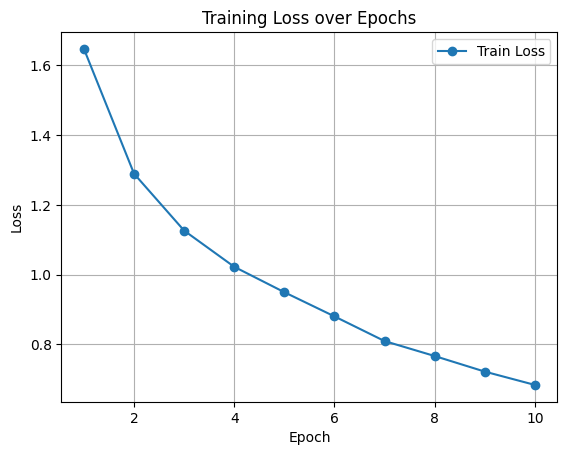

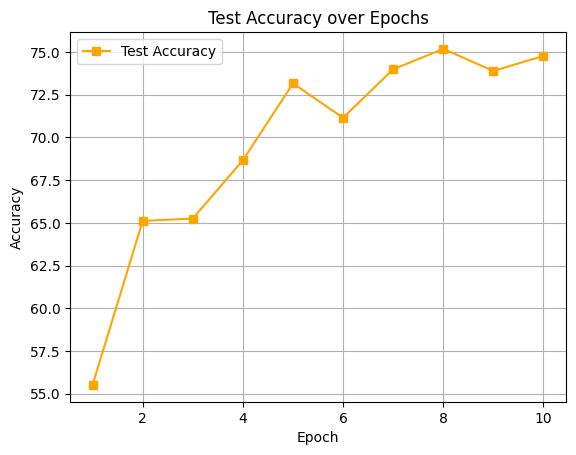

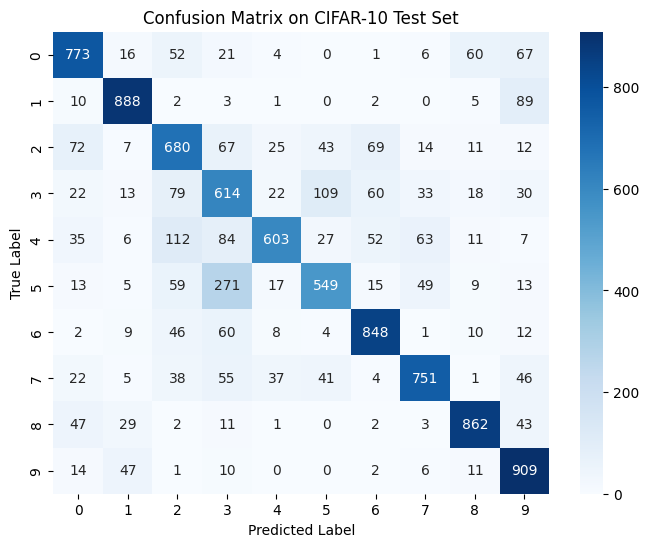

Prediction: [3 8 0 0 6 6 1 6 3 1]
Actual:     [3 8 8 0 6 6 1 6 3 1]


In [14]:
# 步骤六：模型评估
# 6.1 最后一次测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制训练loss变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), train_losses, marker='o', label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/train_loss_curve.png')
plt.show()

# 6.3 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(1, EPOCH+1), test_accuracies, marker='s', color='orange', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.savefig('./output/test_accuracy_curve.png')
plt.show()

# 6.4 绘制混淆矩阵
conf_mat = confusion_matrix(true_y.numpy(), pred_y.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on CIFAR-10 Test Set")
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.5 打印前10个预测结果
print('Prediction:', pred_y[:10].numpy())
print('Actual:    ', true_y[:10].numpy())

In [15]:
# 步骤七：保存模型与结果
# 请在此处编写代码：保存模型
torch.save(cnn.state_dict(), './output/cnn_cifar10.pth')
print("Model saved at ./output/cnn_cifar10.pth")

Model saved at ./output/cnn_cifar10.pth


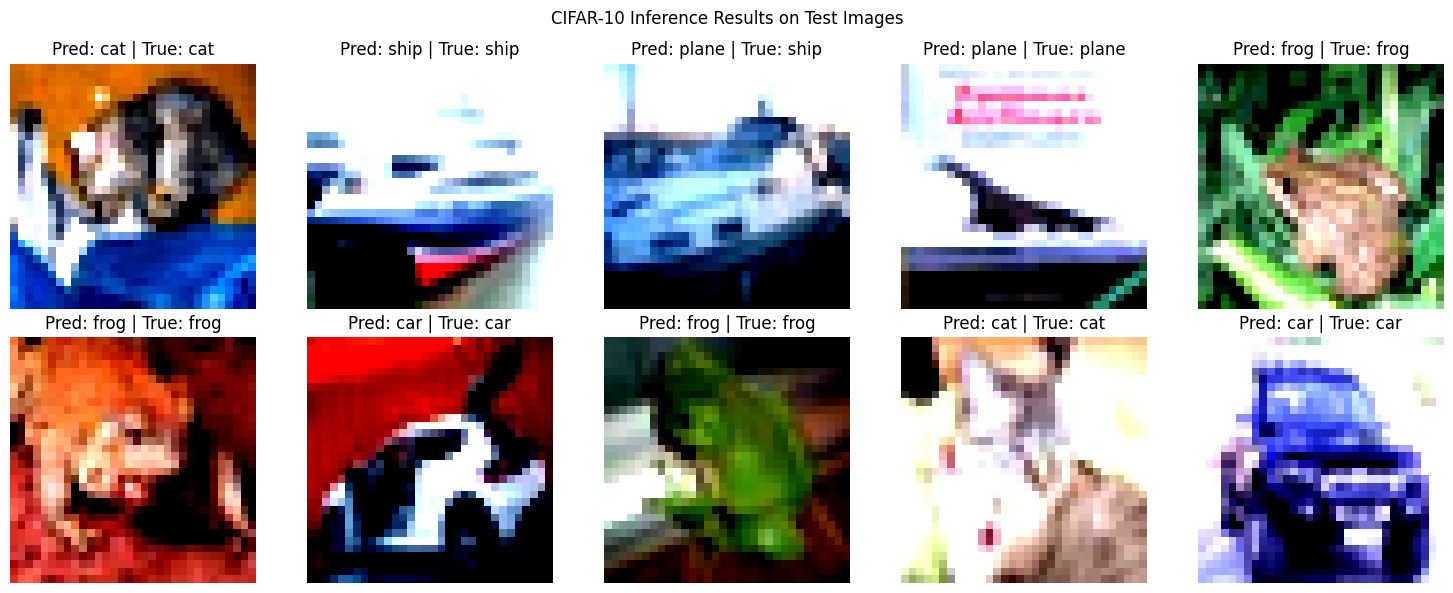

In [17]:
# 步骤八：推理结果可视化
# 8.1 CIFAR10 类别标签
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 8.2 可视化推理函数
def visualize_cifar10_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 CIFAR-10 测试集上的部分预测结果（RGB 彩色图）
    """
    model.eval()  # 请在此处编写代码：将模型设置为 eval 模式
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 请在此处编写代码：将 inputs 和 targets 迁移到指定设备
            outputs = model(inputs)  # 请在此处编写代码：前向传播获得模型输出
            _, predicted = outputs.max(1)  # 请在此处编写代码：获取预测结果

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                # 请在此处编写代码：提取第 i 张图像并反归一化，还原为 (32, 32, 3)
                img = inputs[i].cpu().numpy().transpose((1, 2, 0))
                img = img * 0.5 + 0.5
                img = img.clip(0, 1)

                true_label = classes[targets[i].item()]  # 请在此处编写代码：获取真实类别名称
                pred_label = classes[predicted[i].item()]  # 请在此处编写代码：获取预测类别名称

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {pred_label} | True: {true_label}")
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("CIFAR-10 Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/cifar10_test_predictions.png')
    plt.show()

# 8.3 执行推理可视化
visualize_cifar10_predictions(cnn, test_loader, device=DEVICE, num_images=10)